In [1]:
# Shay Redding
# 11/27

In [2]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings 
from scipy import stats

# visual style
sns.set(style='whitegrid')
# declutter warnings
warnings.filterwarnings('ignore')

In [21]:
# Load Data and Quick Clean for binary classification

# load data
data = pd.read_csv('../data/raw/TWOSIDES.csv', nrows=500000, low_memory=False)

# remove columns we don't care about and rename columns for ease
data = data.rename(columns={
    'drug_1_concept_name': 'drug_1',
    'drug_2_concept_name': 'drug_2',
    'condition_concept_name': 'condition'})
necessary_columns = ['drug_1', 'drug_2', 'condition', 'PRR', 'PRR_error', 'mean_reporting_frequency']
data = data[necessary_columns]

# remove 'drug_1/2_concept_name' from rows
data = data[
    ~data['drug_1'].str.contains('concept_name', case=False, na=False) &
    ~data['drug_2'].str.contains('concept_name', case=False, na=False)
]

data = data.drop_duplicates()
data = data.drop_duplicates(subset=['drug_1', 'drug_2', 'condition'])

In [4]:
# Data Overview

print(f'Columns:\n{data.columns.tolist()}\n')
print(f'Shape: {data.shape[0]} rows x {data.shape[1]} columns\n')
print(f'Data Types:\n{data.dtypes}\n')

# missing values
missing = data.isnull().sum()

if missing.sum() == 0:
    print('no missing values.')

Columns:
['drug_1', 'drug_2', 'condition', 'PRR', 'PRR_error', 'mean_reporting_frequency']

Shape: 786739 rows x 6 columns

Data Types:
drug_1                       object
drug_2                       object
condition                    object
PRR                         float64
PRR_error                    object
mean_reporting_frequency     object
dtype: object

no missing values.


In [5]:
# Basic Stats

# unique drug count
unique_drug_1 = data['drug_1'].nunique()
unique_drug_2 = data['drug_2'].nunique()
unique_drugs = set(data['drug_1']) | set(data['drug_2'])
unique_count = len(unique_drugs)

print(f'Unique drugs in col 1: {unique_drug_1}')
print(f'Unique drugs in col 2: {unique_drug_2}')
print(f'Total  drugs: {unique_count}')

# interaction counts
drug_count = pd.concat([
    data['drug_1'].value_counts(),
    data['drug_2'].value_counts()]).groupby(level=0).sum()

# per drug interactions
print(f'Mean interactions: {drug_count.mean():.2f}')
print(f'Median interactions: {drug_count.median():.2f}')
print(f'Standard deviation: {drug_count.std():.2f}')
print(f'Minimum interactions: {drug_count.min():.2f}')
print(f'Maximum interactions: {drug_count.max():.2f}')

# quartiles
Q1, Q2, Q3 = drug_count.quantile([0.25, 0.5, 0.75])

print('\nInteraction Quartiles:')
print(f'Q1: {Q1}')
print(f'Q2: {Q2}')
print(f'Q3: {Q3}')

# interquartile range
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
outliers = drug_count[(drug_count < lower_bound) | (drug_count > upper_bound)]

print(f'\nIQR outliers: {len(outliers)}')
print('\nTop 10 outliers:')
for drug, count in outliers.nlargest(10).items():
    print(f'{drug}: {count}')

Unique drugs in col 1: 984
Unique drugs in col 2: 1078
Total  drugs: 1317
Mean interactions: 1194.74
Median interactions: 310.00
Standard deviation: 2165.46
Minimum interactions: 1.00
Maximum interactions: 17765.00

Interaction Quartiles:
Q1: 74.0
Q2: 310.0
Q3: 1317.0

IQR outliers: 144

Top 10 outliers:
Prednisone: 17765
Furosemide: 15643
Oxycodone: 15013
Aspirin: 14583
zolpidem: 14464
Potassium Chloride: 14359
Amlodipine: 13257
levothyroxine: 12678
atorvastatin: 12641
pantoprazole: 12264


In [6]:
# Basic Frequency Analysis

drug_1_count = data['drug_1'].value_counts()
drug_2_count = data['drug_2'].value_counts()
total_drug_count = pd.concat([drug_1_count, drug_2_count]).groupby(level=0).sum()

# list top 25 
print(f'\nMost Interactive Drugs:')
top_25 = total_drug_count.nlargest(25)
print(f"{'Rank':<6} {'Drug Name':<40} {'Interactions':>12}")
for rank, (drug, count) in enumerate(top_25.items(), 1):
    print(f'{rank:<6} {drug:<40} {count:>12,}')

# list bottom 25 
bot_25 = total_drug_count.nsmallest(25)
print(f'\nLeast Interactive Drugs:')
print(f"{'Rank':<6} {'Drug Name':<40} {'Interactions':>12}")
for rank, (drug, count) in enumerate(bot_25.items(), 1):
    print(f'{rank:<6} {drug:<40} {count:>12,}')


Most Interactive Drugs:
Rank   Drug Name                                Interactions
1      Prednisone                                     17,765
2      Furosemide                                     15,643
3      Oxycodone                                      15,013
4      Aspirin                                        14,583
5      zolpidem                                       14,464
6      Potassium Chloride                             14,359
7      Amlodipine                                     13,257
8      levothyroxine                                  12,678
9      atorvastatin                                   12,641
10     pantoprazole                                   12,264
11     gabapentin                                     11,557
12     Metoprolol                                     11,125
13     Omeprazole                                     11,121
14     Morphine                                       10,649
15     Lisinopril                                     10,115

In [7]:
# Specific Interaction Patterns
pair_counts = data.groupby(['drug_1', 'drug_2']).size().sort_values(ascending=False)

for i, ((drug_1, drug_2), count) in enumerate(pair_counts.head(25). items(), 1):
    print(f'{i:2d}. {drug_1} - {drug_2}: {count} interactions')


 1. Acetaminophen - zolpidem: 2852 interactions
 2. Aspirin - atorvastatin: 2674 interactions
 3. Furosemide - Albuterol: 2496 interactions
 4. Amlodipine - levothyroxine: 2298 interactions
 5. Oxycodone - Omeprazole: 2246 interactions
 6. atorvastatin - Prednisone: 2119 interactions
 7. Hydrocodone - Morphine: 2060 interactions
 8. Lisinopril - zolpidem: 1944 interactions
 9. Furosemide - Methylprednisolone: 1862 interactions
10. Calcium Carbonate - Prednisone: 1724 interactions
11. Citalopram - gabapentin: 1686 interactions
12. Esomeprazole - Clonazepam: 1675 interactions
13. Amlodipine - Folic Acid: 1670 interactions
14. Oxycodone - Metoclopramide: 1662 interactions
15. Ondansetron - Fentanyl: 1657 interactions
16. Paroxetine - gabapentin: 1621 interactions
17. pantoprazole - Dexamethasone: 1611 interactions
18. zolpidem - Bupropion: 1597 interactions
19. Folic Acid - Potassium Chloride: 1572 interactions
20. Paroxetine - levothyroxine: 1560 interactions
21. Hydrocodone - Naproxen: 

In [8]:
# Basic Statistical Tests

# normality
stat, p_value = stats.shapiro(total_drug_count.sample(min(5000, len(total_drug_count))))
print(f"   Statistic: {stat:.4f}")
print(f"   P-value: {p_value:.4e}")

skewness = total_drug_count.skew()
kurtosis = total_drug_count.kurt()

print(f'   Skewness: {skewness:.4f}')
print(f'   Kurtosis: {kurtosis:.4f}')

print(f' High skewness (>1) here means that a few drugs have many interactions.')
print(f' High Kurtosis value (>3) here means there are many outliers.')


   Statistic: 0.5796
   P-value: 1.3980e-48
   Skewness: 3.2854
   Kurtosis: 13.4015
 High skewness (>1) here means that a few drugs have many interactions.
 High Kurtosis value (>3) here means there are many outliers.


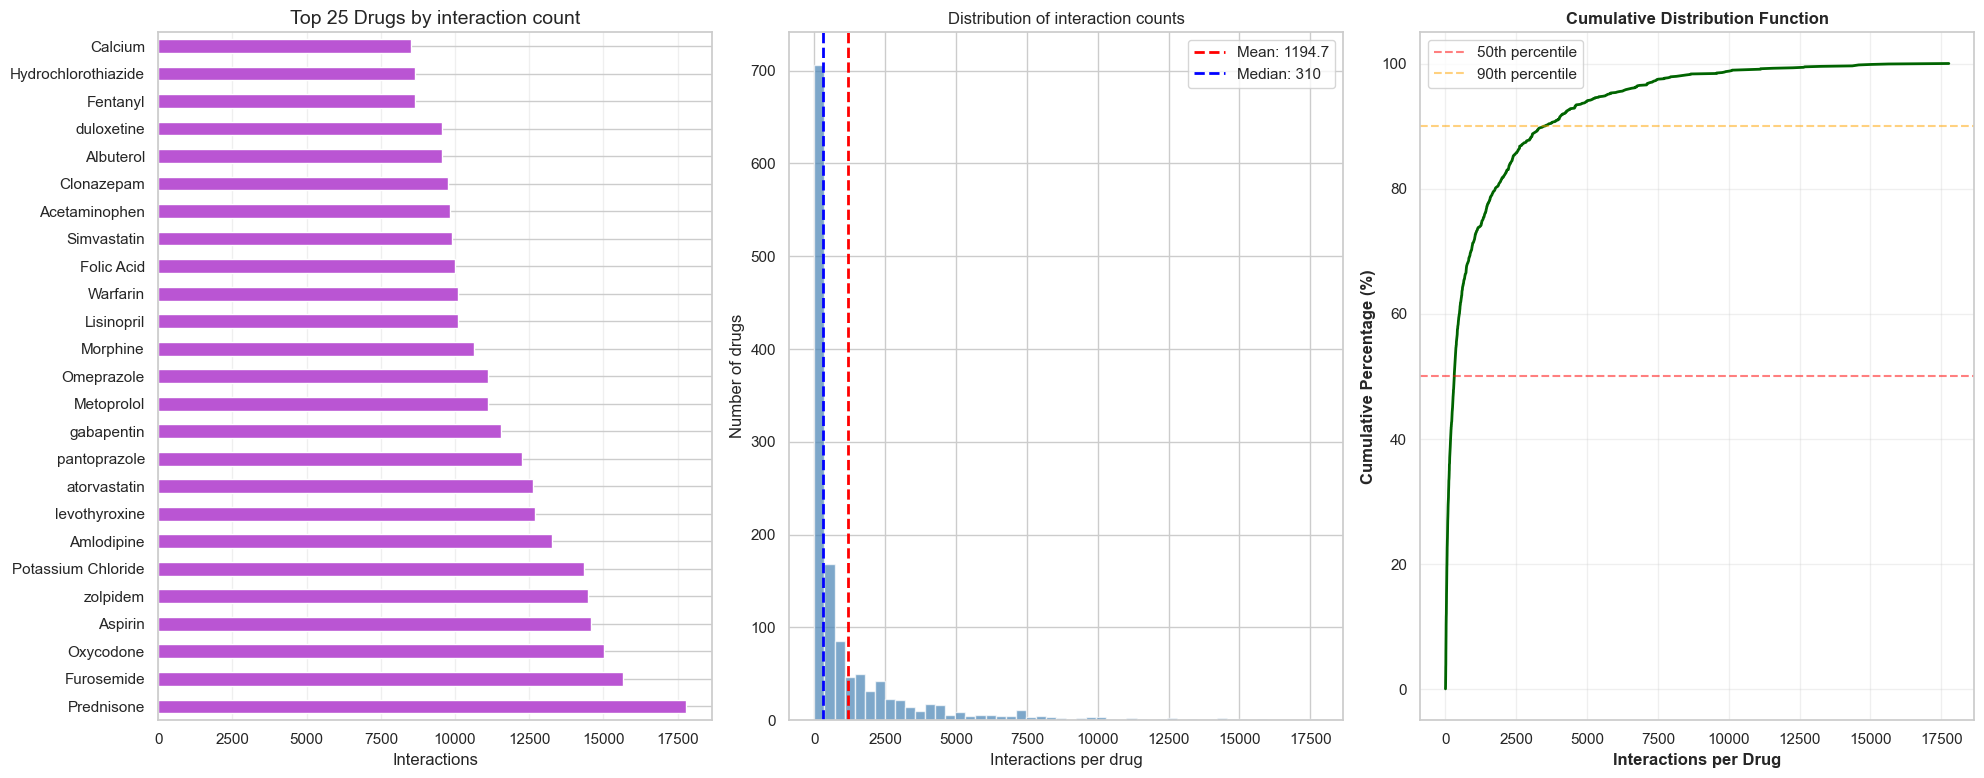

In [9]:
# Visualizations

figure = plt.figure(figsize=(20, 15))

# top drug bar chart
chart1 = plt.subplot(2, 3, 1)
top_25.plot(kind='barh', ax=chart1, color='mediumorchid')
chart1.set_xlabel('Interactions')
chart1.set_title('Top 25 Drugs by interaction count', fontsize=14)
chart1.grid(axis='x', alpha=0.3)

# distribution histo
chart2 = plt.subplot(2, 3, 2)
chart2.hist(total_drug_count, bins=50, color='steelblue', alpha=0.7)
chart2.axvline(total_drug_count.mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {total_drug_count.mean():.1f}')
chart2.axvline(total_drug_count.median(), color='blue', linestyle='--', linewidth=2, label=f'Median: {total_drug_count.median():.0f}')
chart2.set_xlabel('Interactions per drug')
chart2.set_ylabel('Number of drugs')
chart2.set_title('Distribution of interaction counts')
chart2.legend()

# distribution
chart3 = plt.subplot(2, 3, 3)
sorted_counts = np.sort(total_drug_count)
cumulative = np.arange(1, len(sorted_counts) + 1) / len(sorted_counts) * 100
chart3.plot(sorted_counts, cumulative, linewidth=2, color='darkgreen')
chart3.axhline(50, color='red', linestyle='--', alpha=0.5, label='50th percentile')
chart3.axhline(90, color='orange', linestyle='--', alpha=0.5, label='90th percentile')
chart3.set_xlabel('Interactions per Drug', fontweight='bold')
chart3.set_ylabel('Cumulative Percentage (%)', fontweight='bold')
chart3.set_title('Cumulative Distribution Function', fontweight='bold', fontsize=12)
chart3.legend()
chart3.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('../figures/initial-eda-charts.png', dpi=300, bbox_inches='tight')
plt.show()

# heatmap


In [31]:
# Initial Conclusions
# figure out duplicates with this data

print(f'''
Summary:
    total drug pairs: {len(data)}
    unique drugs: {unique_count}
    average interaction per drug: {total_drug_count.mean():.2f}
    missing values: {missing.sum()} 
    # duplicates

Distribution/Statistical Properties:
    skewness: {skewness:.2f}; indicates right-skewed distribution
    top 5% of drugs have: {drug_count.quantile(0.95):.0f} interactions
    outliers: {len(outliers)}
    p-value: {p_value:.4e}; indicates non-normal distribution
    
Interaction Patterns:
    most interactive drug: {drug_count.idxmax()} ({drug_count.max()} interactions)

    ''')



summary_stats = pd.DataFrame({
    'Metric': [
        'Total Interactions', 'Unique Drugs', 'Mean Interactions/Drug',
        'Median Interactions/Drug', 'Std Dev', 'Skewness', 'Kurtosis',
        'Outliers'
    ],
    'Value': [
        f'{len(data):,}', f'{unique_count:,}', f'{drug_count.mean():.2f}',
        f'{drug_count.median():.0f}', f'{drug_count.std():.2f}',
        f'{skewness:.4f}', f'{kurtosis:.4f}', f'{len(outliers)}'
    ]
})

summary_stats.to_csv('../data/processed/eda_summary.csv', index=False)


Summary:
    total drug pairs: 390728
    unique drugs: 1317
    average interaction per drug: 1194.74
    missing values: 0 
    # duplicates

Distribution/Statistical Properties:
    skewness: 3.29; indicates right-skewed distribution
    top 5% of drugs have: 5703 interactions
    outliers: 144
    p-value: 1.3980e-48; indicates non-normal distribution

Interaction Patterns:
    most interactive drug: Prednisone (17765 interactions)

    


In [22]:
# clean for binary classification

# convert prr to float
data['PRR'] = pd.to_numeric(data['PRR'])

# filter for only significant interactions
print(f'before filtering for prr >= 2: {len(data)}')
data = data[data['PRR'] >= 2.0]
print(f'after filtering for prr >= 2: {len(data)}')

# group by drug pair and amount of interactions
data_binary = data.groupby(['drug_1', 'drug_2']).size().reset_index(name='num_side_effects')

print(f"Average side effects per pair: {data_binary['num_side_effects'].mean():.1f}")
print(f"Median side effects per pair: {data_binary['num_side_effects'].median():.0f}")
print(f"Max side effects for one pair: {data_binary['num_side_effects'].max()}")



before filtering for prr >= 2: 498999
after filtering for prr >= 2: 390728
Average side effects per pair: 157.9
Median side effects per pair: 66
Max side effects for one pair: 2674
